# Model Architecture

1276 total files, 962 train files (75%)

In [1]:
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import collections

## Multi-Head Relative Attention

In [23]:
class MultiHeadRelativeAttention(keras.layers.Layer):
    """
    An implementation of the multi head attention mechanism, with relative position representations. 
    The input K, and V matrices have the shape of (batch, seqlen, dim). The input Q matrix has the shape (batch, query_seqlen, dim).
    The output shape will equal the shape of the query matrix. 
    :params:
        heads: the number of heads to project q, k, and v matrices
        max_relative_pos: the max relative position that will be considered,
        key_dim: the dimensions of the weighted query and key matrices
        value_dim: the dimensions of the weighted value matrices
        kernel_constraint: weight constraints applied to Q, K, V weights
    """
    def __init__(self, heads, max_relative_pos, key_dim=None, value_dim=None, kernel_constraint=None, **kwargs):
        super().__init__(**kwargs)
        # query and key will have the same dimensions. value may or may not have the same dimensions. if value 
        # not specified, then value = key
        # query may have different seqlen
        self.heads = heads
        self.key_dim = key_dim
        self.value_dim = value_dim
        self.max_relative_pos = max_relative_pos
        self.kernel_constraint = kernel_constraint

    def build(self, input_shape):
        batch, query_seqlen, dim_input = input_shape

        # dims calculation
        qk_dim = self.key_dim or dim_input
        v_dim = self.value_dim or dim_input
        assert qk_dim % self.heads == 0, """q, k dims must be a multiple of heads"""
        assert v_dim % self.heads == 0, """v dims must be a multiple of heads"""
        self.head_qk_dim = qk_dim // self.heads
        self.head_v_dim = v_dim // self.heads
 
        # relative positional encoding
        num_rprs = self.max_relative_pos * 2 + 1
        self.rpr_key_embedding = keras.layers.Embedding(
            num_rprs, self.head_qk_dim, embeddings_constraint=self.kernel_constraint, name="relative embedding (key)")
        self.rpr_value_embedding = keras.layers.Embedding(
            num_rprs, self.head_v_dim, embeddings_constraint=self.kernel_constraint, name="relative embedding (value)")
        self.rpr_lookup = self._generate_rpr_lookup(query_seqlen, self.max_relative_pos)

        # project to heads after applying weights/dense
        self.weights_q = keras.layers.Dense(
            qk_dim, use_bias=False, kernel_constraint=self.kernel_constraint, name="query weights")
        self.weights_k = keras.layers.Dense(
            qk_dim, use_bias=False, kernel_constraint=self.kernel_constraint, name="key weights")
        self.weights_v = keras.layers.Dense(
            v_dim, use_bias=False, kernel_constraint=self.kernel_constraint, name="value weights")

        # concatenated heads passed as input
        self.concat_head_weights = keras.layers.Dense(
            input_shape[-1], kernel_constraint=self.kernel_constraint, name="concat weights")

        super().build(input_shape)

    def _generate_rpr_lookup(self, query_seqlen, max_relative_pos):
        x = np.arange(query_seqlen)
        x = tf.expand_dims(x, axis=0) - tf.expand_dims(x, axis=1)
        x = tf.clip_by_value(x, -max_relative_pos, max_relative_pos)
        return x + max_relative_pos

    def call(self, query, value, key=None, mask=None):
        """
        params:
            query: tensor of shape (batch, q_seqlen, dim)
            key: tensor of shape (batch, seqlen, dim)
            value: tensor of shape (batch, seqlen, dim)
            mask: tensor with shape equal to or broadcastable to (batch, q_seqlen, seqlen) to be applied to each attn head
        :returns:
            attn_scores: Attention scores with shape (..., q_seqlen, dim), i.e., the attention scores
                for each head in each batch
            attn_weights: Attention weights applied to the value tensor
        """
        if key is not None:
            key = value
        batch_size = tf.shape(query)[0] # or tf.shape(key)[0]
        dim_input = tf.shape(query)[-1]

        # forward pass through weights and split (after for efficiency)
        query = self._project_to_heads(self.weights_q(query))
        key = self._project_to_heads(self.weights_k(key))
        value = self._project_to_heads(self.weights_v(value))   

        # compute attention scores and grab weights
        attn_scores, attn_weights = self._compute_attn(query, value, key, mask)

        # transpose and reshape to concat scores for each head in each batch
        attn_scores = tf.transpose(attn_scores, perm=[0, 2, 1, 3]) # (batch_size, seqlen, heads, head_dim)
        concat_attn = tf.reshape(attn_scores, (batch_size, -1, dim_input)) # (batch_size, seqlen, dim)

        out = self.concat_head_weights(concat_attn)
        return out, attn_weights

    def _project_to_heads(self, x):
        """
        projects x to `heads` number of heads
        params:
            x: tensor of shape (batch, seqlen, dim)
        returns:
            tensor of shape (batch, heads, seqlen, head_dim). Each sequence in the batch is 
                split column wise so that each head attends to a subsection of dim in each sequence.
        example:
            x with shape (batch=2, seqlen=3, dim=4)
            [[[ 0,  1,  2,  3],
              [ 4,  5,  6,  7],
              [ 8,  9, 10, 11]],

             [[12, 13, 14, 15],
              [16, 17, 18, 19],
              [20, 21, 22, 23]]]
            reshape to (batch=2, seqlen=3, heads=2, head_dim=2)
            [[[[ 0,  1],
               [ 2,  3]],
              [[ 4,  5],
               [ 6,  7]],
              [[ 8,  9],
               [10, 11]]],
             [[[12, 13],
               [14, 15]],
              [[16, 17],
               [18, 19]],
              [[20, 21],
               [22, 23]]]])
            transpose to (batch=2, heads=2, seqlen=3, head_dim=2)
            [[[[ 0,  1],
               [ 4,  5],
               [ 8,  9]],
              [[ 2,  3],
               [ 6,  7],
               [10, 11]]],
             [[[12, 13],
               [16, 17],
               [20, 21]],
              [[14, 15],
               [18, 19],
               [22, 23]]]])
            
        """
        x = tf.reshape(x, (x.shape[0], x.shape[1], self.heads, -1))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def _compute_relative(self, x, embeddings, transpose_embeddings=False):
        """
        computes relational attention across all input sequences in heads and batches. x has 
        input shape (batch, heads, seqlen, head_dim) where head_dim refers to either head_qk_dim or head_v_dim.
        
        For query, `x` is transposed to (q_seqlen, batch, heads, head_dim), reshaped to 
        (q_seqlen, batch * heads, head_dim), then multiplied with embeddings with shape 
        (q_seqlen, head_dim, q_seqlen) (after transpose). The resulting shape is 
        (q_seqlen, batch * heads, q_seqlen). 
        
        For attn_weights, `x` is transposed to (q_seqlen, batch, heads, q_seqlen), reshaped to 
        (q_seqlen, batch * heads, q_seqlen), then multiplied with embeddings with shape 
        (q_seqlen, q_seqlen, head_dim). The resulting shape is (q_seqlen, batch * heads, head_dim). 
        In both cases, the result wil be reshaped back to (q_seqlen, batch, heads, ...), then transposed back to 
        (batch, heads, q_seqlen, ...). This approach avoids broadcasting.
        params:
            x: tensor (query or attn weights) with shape (batch, heads, q_seqlen, head_dim)
            embeddings: learned rpr embeddings with shape (q_seqlen, q_seqlen, head_dim)
            transpose_embeddings: Whether to transpose the embeddings argument, pass true for query 
        """
        x = tf.transpose(x, perm=[2, 0, 1, 3]) # (q_seqlen, batch, heads, head_dim)
        x = tf.reshape(x, (x.shape[0], -1, x.shape[-1])) # (q_seqlen, batch * heads, head_dim)
        x = tf.matmul(x, embeddings, transpose_b=transpose_embeddings) # (q_seqlen, batch * heads, q_seqlen)
        x = tf.reshape(x, (x.shape[0], -1, self.heads, x.shape[-1])) # (q_seqlen, batch, heads, q_seqlen)
        return tf.transpose(x, perm=[1, 2, 0, 3])

    def _compute_attn(self, query, value, key, mask):
        """

        :params:
            query: tensors of shape (batch, heads, q_seqlen, head_qk_dim)
            value: tensors of shape (batch, heads, seqlen, head_v_dim)
            key: tensors of shape (batch, heads, seqlen, head_qk_dim)
            mask: tensor with shape equal to or broadcastable to (batch, q_seqlen, seqlen) 
                  applied after first matmul and just prior to softmax
        :returns:
            attn_scores: Attention scores with shape (..., seqlen, dim), i.e., the attention scores
                for each head in each batch
            attn_weights: Attention weights applied to the value tensor
        """
        # technically, value may have a different dim, resulting in an attention shape of (..., seqlen, dim_v)
        # query and key must have the same dimensions
        key_dims = tf.shape(key)[-1]

        alpha = tf.matmul(query, key, transpose_b=True) 
        rpr_key_embedding = self.rpr_key_embedding(self.rpr_lookup)
        alpha += self._compute_relative(query, rpr_key_embedding, transpose_embeddings=True)
        alpha /= tf.sqrt(tf.cast(key_dims, tf.float32))

        if mask:
            alpha += mask[:, tf.newaxis, :, :] * -np.inf
        attn_weights = tf.nn.softmax(alpha) # default last axis (key_dims)
        attn_scores = tf.matmul(attn_weights, value)
        rpr_value_embedding = self.rpr_value_embedding(self.rpr_lookup)
        attn_scores += self._compute_relative(attn_weights, rpr_value_embedding, transpose_embeddings=False)

        return attn_scores, attn_weights

    @classmethod
    def from_config(cls, **kwargs):
        return cls(**kwargs)

    def get_config(self):
        config = super().get_config()
        config.update(dict(
            heads=self.heads,
            max_relative_pos=self.max_relative_pos,
            key_dim=self.key_dim,
            value_dim=self.value_dim,,
            kernel_constraint=self.kernel_constraint.get_config()
        ))
        return config

## Encoder

In [3]:
class Encoder(keras.layers.Layer):
    def __init__(self, heads, ffnn_dim, max_relative_pos, dropout_rate=0.2, kernel_constraint=None, **kwargs):
        super().__init__(**kwargs)
        self.heads = heads
        self.ffnn_dim = ffnn_dim
        self.dropout_rate = dropout_rate
        self.kernel_constraint = kernel_cosntraint
        self.attn = dict(
            layer=MultiHeadRelativeAttention(
                heads=heads, 
                max_relative_pos=max_relative_pos, 
                name="Encoder Relative Attention"),
            dropout=keras.layers.Dropout(rate=dropout_rate),
            norm=keras.layers.LayerNormalization())

    def build(self, input_shape):
        embed_dim = input_shape[-1]
        self.ffnn = dict(
            layer=keras.Sequential([
                keras.layers.Dense(self.ffnn_dim, kernel_constraint=self.kernel_constraint, activation="relu"),
                keras.layers.Dense(embed_dim, kernel_constraint=self.kernel_constraint)
            ], name="Encoder Pointwise Feed Forward"),
            dropout=keras.layers.Dropout(rate=self.dropout_rate),
            norm=keras.layers.LayerNormalization())
        super().build(input_shape)
    
    def call(self, inputs, padding_mask, training):
        attn_out, attn_weights = self.attn['layer'](query=inputs, key=inputs, value=inputs, mask=padding_mask)
        attn_out = self.attn['dropout'](attn_out, training=training)
        attn_out = self.attn['norm'](inputs + attn_out)

        ffnn_out = self.ffnn['layer'](attn_out)
        ffnn_out = self.ffnn['dropout'](ffnn_out, training=training)
        ffnn_out = self.ffnn['norm'](attn_out + ffnn_out)
        return ffnn_out, attn_weights

    def get_config(self):
        config = super().get_config()
        config.update(dict(
            embed_dim=self.embed_dim,
            heads=self.heads,
            ffnn_dim=self.ffnn_dim,
            dropout_rate=self.dropout_rate,
            kernel_constraint=self.kernel_constraint.get_config()
        ))
        return config
    
    @classmethod
    def from_config(cls, **kwargs):
        return NotImplemented

In [4]:
class EncoderStack(keras.layers.Layer):
    def __init__(self, units, heads, ffnn_dim, max_relative_pos, dropout_rate=0.2, kernel_constraint=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.heads = heads
        self.ffnn_dim = ffnn_dim
        self.dropout_rate = dropout_rate
        self.max_relative_pos = max_relative_pos
        self.kernel_constraint = kernel_constraint
        self.encoders = [Encoder(self.heads, self.ffnn_dim, self.max_relative_pos, self.dropout_rate, self.kernel_constraint) 
                         for i in range(self.units)]
    
    def call(self, inputs, padding_mask, training):
        all_attn_weights = dict()
        for i, layer in enumerate(self.encoders):
            inputs, attn_weights = layer(inputs, padding_mask, training)
            all_attn_weights[f'encoder_{i}'] = attn_weights
        return inputs, all_attn_weights
    
    def get_config(self):
        config = super().get_config()
        config.update(dict(
            units=self.units,
            heads=self.heads,
            ffnn_dim=self.ffnn_dim,
            dropout_rate=self.dropout_rate,
            kernel_constraint=self.kernel_constraint.get_config()
        ))
        return config

    @classmethod
    def from_config(cls, **kwargs):
        return NotImplemented

## Decoder

In [5]:
class Decoder(keras.layers.Layer):
    def __init__(self, heads, max_relative_pos, ffnn_dim, dropout_rate=0.2, kernel_constraint=None, **kwargs):
        super().__init__(**kwargs)
        self.heads = heads
        self.max_relative_pos = max_relative_pos
        self.ffnn_dim = ffnn_dim
        self.dropout_rate = dropout_rate
        self.kernel_constraint = kernel_constraint
        self.attn = dict(
            # use either specified key_dim (recommended key_dim < embed_dim) or just keep same size
            layer=MultiHeadRelativeAttention(
                heads=heads, 
                max_relative_pos=max_relative_pos,
                name="Decoder Relative Attention"),
            dropout=keras.layers.Dropout(rate=dropout_rate),
            norm=keras.layers.LayerNormalization()
        )
        self.encdec_attn = dict(
            layer=MultiHeadRelativeAttention(
                heads=heads, 
                max_relative_pos=max_relative_pos, 
                name="Encoder-Decoder Relative Attention"),
            dropout=keras.layers.Dropout(rate=dropout_rate),
            norm=keras.layers.LayerNormalization()
        )

    def build(self, input_shape):
        embed_dim = input_shape[-1]
        self.ffnn = dict(
            layer=keras.Sequential([
                keras.layers.Dense(self.ffnn_dim, kernel_constraint=self.kernel_constraint, activation="relu"),
                keras.layers.Dense(embed_dim, kernel_constraint=self.kernel_constraint)
            ], name="Decoder Pointwise Feed Forward"),
            dropout=keras.layers.Dropout(rate=self.dropout_rate),
            norm=keras.layers.LayerNormalization()
        )
        super().build(input_shape)

    def call(self, inputs, enc_kv, padding_mask, lookahead_mask, training):
        # when q, k, and v are same, this is self attention
        # otherwise it is performing cross attention
        attn_out, attn_weights = self.attn['layer'](query=inputs, key=inputs, value=inputs, mask=lookahead_mask)
        attn_out = self.attn['dropout'](attn_out, training=training)
        attn_out = self.attn['norm'](inputs + attn_out)

        encdec_attn_out, encdec_attn_weights = self.encdec['layer'](query=attn_out, key=enc_kv, value=enc_kv, mask=padding_mask)
        encdec_attn_out = self.encdec['dropout'](encdec_attn_out, training=training)
        encdec_attn_out = self.encdec['norm'](attn_out + encdec_attn_out)

        ffnn_out = self.ffnn['layer'](encdec_attn_out)
        ffnn_out = self.ffnn['dropout'](ffnn_out, training=training)
        ffnn_out = self.ffnn['norm'](ffnn_out + encdec_attn_out)
        return ffnn_out, attn_weights, encdec_attn_weights

    def get_config(self):
        config = super().get_config()
        config.update(dict(
            embed_dim=self.embed_dim,
            heads=self.heads,
            ffnn_dim=self.ffnn_dim,
            dropout_rate=self.dropout_rate,
            kernel_constraint=self.kernel_constraint.get_config()
        ))
        return config

    @classmethod
    def from_config(cls, **kwargs):
        return cls(**kwargs)

In [6]:
class DecoderStack(keras.layers.Layer):
    def __init__(self, units, heads, ffnn_dim, max_relative_pos, dropout_rate=0.2, kernel_constraint=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.heads = heads
        self.ffnn_dim = ffnn_dim
        self.max_relative_pos = max_relative_pos
        self.dropout_rate = dropout_rate
        self.kernel_constraint = kernel_constraint
        self.decoders = [Decoder(self.heads, self.ffnn_dim, self.max_relative_pos, self.dropout_rate, self.kernel_constraint)
                         for i in range(self.units)]

    def call(self, inputs, enc_kv, padding_mask, lookahead_mask, training):
        all_attn_weights = dict()
        DecoderAttentionWeights = collections.namedtuple('DecoderAttentionWeights', ['self_attn', 'cross_attn'])
        for i, layer in enumerate(self.decoders):
            inputs, *attn_weights = layer(inputs, enc_kv, padding_mask, lookahead_mask, training)
            all_attn_weights[f'decoder_{i}'] = DecoderAttentionWeights(*attn_weights)
        return inputs, all_attn_weights

    def get_config(self):
        config = super().get_config()
        config.update(dict(
            units=self.units,
            embed_dim=self.embed_dim,
            heads=self.heads,
            ffnn_dim=self.ffnn_dim,
            dropout_rate=self.dropout_rate,
            kernel_constraint=self.kernel_constraint
        ))
        return config

    @classmethod
    def from_config(cls, **kwargs):
        return cls(**kwargs)

## Tokenizer

In [29]:
class MidiTokenizer:
    """
    stores the vocabulary for a given input sequence, and encodes elements of the sequence into integer labels.
    Starts with a label of 1.
    """
    def __init__(self):
        self.mappings = dict()

    def get_label(self, element) -> int:
        if element not in self.mappings:
            self.mappings[element] = len(self.mappings) + 1
        return self.mappings[element]
    
    def encode(self, sequence) -> list:
        return [get_label(el) for el in sequence]

    def __len__(self):
        return len(self.mappings)
    
    def vocab_size(self):
        return len(self)

## Embeddings

### Positional Embeddings


$$\large{\overrightarrow{p_t}^{(i)} = \begin{cases} sin(\omega(k) * t), & \mbox{if  } i = 2 * k \\ cos(\omega(k) * t), & \mbox{if  } i = 2 * k + 1 \end{cases}}$$

$$\large{\omega(k) = \frac{1}{10000^{2k / d}}}$$

In [7]:
OMEGA_SCALE = 10000

def omega(k, dims):
    return 1 / (np.power(OMEGA_SCALE, 2 * k / np.float64(dims)))

def positional_embeddings(max_pos, dims):
    """
    Returns a 2-d numpy array with shape (max_pos, dims) representing positional embeddings up to `max_pos`
    and compressed into `dims` dimensions
    """
    positions = np.arange(max_pos)[:, np.newaxis]
    embeddings = positions * omega(np.arange(dims, dtype=int) // 2, dims)
    embeddings[:, 0::2] = np.sin(embeddings[:, 0::2])
    embeddings[:, 1::2] = np.cos(embeddings[:, 1::2])
    return embeddings

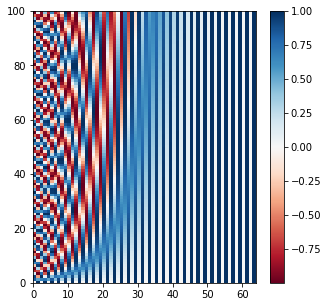

In [8]:
EMBED_DIMS = 64
posembed = positional_embeddings(100, EMBED_DIMS)

fig, ax = plt.subplots(figsize=(5,5))
colormap = ax.pcolormesh(posembed, cmap="RdBu")
ax.set_xlim((0, EMBED_DIMS))
fig.colorbar(colormap, ax=ax)

plt.show()

### Embedding Layer

In [9]:
class Embedding(keras.layers.Layer):
    def __init__(self, vocab_size, output_dim, dropout_rate=0.2, embeddings_constraint=None, **kwargs):
        super().__init__(**kwargs)
        self.vocab_size = vocab_size
        self.output_dim = output_dim
        self.embeddings_constraint = embeddings_constraint
        self.token_embedding = keras.layers.Embedding(
            input_dim=vocab_size, 
            output_dim=output_dim,
            embeddings_constraint=self.embeddings_constraint,
            name="token embedding")
        self.dropout = keras.layers.Dropout(rate=dropout_rate)

    def build(self, input_shape):
        seqlen = input_shape[-1]
        self.positional_embedding = positional_embeddings(seqlen, self.output_dim)
        super().build(input_shape)

    def call(self, inputs, training):
        max_seqlen_in_batch = np.shape(inputs)[-1]
        embed_out = self.token_embedding(inputs)

        # embed_out 3d (batch_size, max_seqlen_in_batch, output_dim) 
        embed_out += self.positional_embedding[:max_seqlen_in_batch]

        # positional_embedding 2d (seqlen, output_dim) compressed to (max_seqlen_in_batch, output_dim)
        # then broadcasted to (batch_size, max_seqlen_in_batch, output_dim), summed with embed_out
        embed_out = self.dropout(embed_out, training=training)

        return embed_out

    def get_config(self):
        config = super().get_config()
        config.update(dict(
            vocab_size=self.vocab_size,
            output_dim=self.output_dim,
            dropout_rate=self.dropout_rate,
            embeddings_constraint=self.embeddings_constraint
        ))
        return config

    @classmethod
    def from_config(cls, **kwargs):
        return cls(**kwargs)

## Masking

In [10]:
def create_padding_mask(inputs, pad_value=0):
    """
    returns tensor with same shape as inputs. The result will have 1's where elements equal pad_value,
    and 0's otherwise.
    params:
        inputs: the input tensor
        pad_value: padding token to compare equality against
    """
    mask = tf.cast(tf.math.equal(inputs, pad_value), tf.float32)
    return mask 

In [11]:
def create_lookahead_mask(dim):
    """
    returns tensor with shape of (dim, dim) where the upper right triangle is populated with 1's and the rest 
    populated with 0. 

    mask[i, j] = 1 if j - i > 0 else 0
    """
    mask  = 1 - tf.linalg.band_part(tf.ones((dim, dim)), -1, 0)
    return mask

In [12]:
def create_decoder_mask(inputs, pad_value=0):
    """
    returns tensor with shape (batch, seqlen, seqlen) given input tensor has shape (batch, seqlen). Combines
    the pad mask and lookahead mask for this batch of input sequences.
    """
    pad_mask = create_padding_mask(inputs, pad_value) # (batch, seqlen)
    lookahead_mask = create_lookahead_mask(inputs.shape[1]) # (seqlen, seqlen)
    pad_mask = pad_mask[:, tf.newaxis, :] # (batch, 1, seqlen)
    return tf.maximum(pad_mask, lookahead_mask)
    

In [27]:
create_decoder_mask(tf.constant([[1, 2, 3, 0, 0],[2, 3, 0, 0, 0]]))[:, np.newaxis, ...]

<tf.Tensor: shape=(2, 1, 5, 5), dtype=float32, numpy=
array([[[[0., 1., 1., 1., 1.],
         [0., 0., 1., 1., 1.],
         [0., 0., 0., 1., 1.],
         [0., 0., 0., 1., 1.],
         [0., 0., 0., 1., 1.]]],


       [[[0., 1., 1., 1., 1.],
         [0., 0., 1., 1., 1.],
         [0., 0., 1., 1., 1.],
         [0., 0., 1., 1., 1.],
         [0., 0., 1., 1., 1.]]]], dtype=float32)>

## Relative Embedding

Because some notes will be played at the same time, these notes must have an embedding that represents that they're played at the same time. I could give these notes the same positional encoding, but this muddies the time relationship between notes, and disregards the fact that notes will be read/generated sequentially, even in a chord. 

I'll **keep the standard positional encoding**, but also add a **chord embedding**, which will use a relative position mechanism (Shaw, Uszkoreit, Vaswani).

## Regularization 
Use l2 MaxNorm weight constraints, Early Stopping, Adam's Optimizer LR Schedule, Dropout

## Model

Use same vocab_size for both encoder and decoder. Because the vocabulary is the same, we can share the embeddings for both encoder and decoder and train with more data. Could embeddings be trained incorrectly due to bad data? No prob not.

In [15]:
class MusicTransformer(keras.Model):
    def __init__(self, vocab_size, embed_dim, layers, heads, 
                 key_dim, value_dim, ffnn_dim, max_relative_pos, dropout_rate, 
                 kernel_constraint=None, **kwargs):
        super().__init__(**kwargs)
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.layers = layers
        self.heads = heads
        self.key_dim = key_dim
        self.value_dim = value_dim
        self.ffnn_dim = ffnn_dim
        self.max_relative_pos = max_relative_pos
        self.dropout_rate = dropout_rate
        self.kernel_constraint = kernel_constraint
        self.encoders = EncoderStack(
            units=layers, 
            heads=heads, 
            ffnn_dim=ffnn_dim, 
            max_relative_pos=max_relative_pos,
            dropout_rate=dropout_rate,
            kernel_constraint=kernel_constraint,
            name=f"Encoder Stack ({layers} layers)")
        self.decoders = DecoderStack(
            units=layers,
            heads=heads,
            ffnn_dim=ffnn_dim,
            max_relative_pos=max_relative_pos,
            dropout_rate=dropout_rate,
            kernel_constraint=kernel_constraint,
            name=f"Decoder Stack ({layers} layers)"
        )
        self.embedding = Embedding(
            output_dim=embed_dim,
            vocab_size=vocab_size,
            dropout_rate=dropout_rate,
            embeddings_constraint=kernel_constraint,
            name="Encoder Embedding"
        ) # dec_embedding can be shared due to same vocab, but on separate vocabs, use different
        self.linear = keras.layers.Dense(vocab_size, activation=keras.activations.softmax, name="Dense Layer + Softmax")

    def call(self, inputs, targets, features, padding_mask, lookahead_mask, training):
        """
        params:
            inputs: tensor of shape (batch, seqlen)
            targets: tensor of shape (batch, target_seqlen)
            padding_mask: tensor with shape equal to or broadcastable to (batch, target_seqlen, seqlen)
            lookahead_mask: tensor with shape equal to or broadcastable to (batch, target_seqlen, seqlen)
            training: boolean representing whether this forward pass is part of training
            features: tensor of shape (batch, dim) for additional features
        returns:
            tensor of shape (batch, target_seqlen, vocab_size)
        """
        enc_out = self.embedding(inputs=inputs)
        enc_out, enc_weights = self.encoders(
            inputs=enc_out, 
            padding_mask=padding_mask, 
            training=training)

        dec_out = self.embedding(inputs=targets)
        dec_out, dec_weights = self.decoders(
            inputs=dec_out, 
            enc_kv=enc_out, 
            padding_mask=padding_mask, # to mask encoder output in cross attn block where padding exists
            lookahead_mask=lookahead_mask, 
            training=training)

        if features is None:
            features = tf.constant([])
        else:
            features = features[:, tf.newaxis, :] # (batch, 1, dim)
            features = tf.tile(features, [1, dec_out.shape[1], 1]) # (batch, dec_out.shape[1], dim)
        concatenated = keras.layers.concatenate([dec_out, features])

        result, decoder_attn_weights = self.linear(concatenated)
        return result, enc_weights, dec_weights

    def _process(self, data):
        inputs, target = data # ([batch, seqlen], [batch, seqlen + 2])

        # ['start', ...], [..., 'end']
        target_input, target_output = target[:, :-1], target[:, 1:]

        # dec_mask (used in self attn block) combines lookahead_mask with dec_key_mask, 
        # while pad_mask (used in cross attn block) masks enc-kv padding
        pad_mask = create_padding_mask(inputs) # (batch, seqlen)
        dec_mask = create_decoder_mask(target_input) # (batch, q_seqlen, seqlen) q_seqlen == seqlen
        
        # mask key portions, the innermost dimension
        # q * k^T has shape (batch, heads, q_seqlen, seqlen), so mask seqlen
        # shape of mask should be (batch, q_seqlen, seqlen) masking seqlen
        pad_mask = pad_mask[:, tf.newaxis, :] # (batch, q_seqlen=1 [broadcast], seqlen)
        return inputs, target_input, target_output, pad_mask, dec_mask
    
    def train_step(self, data):
        inputs, target_input, target_output, pad_mask, dec_mask = self._process(data)
        with tf.GradientTape() as tape:
            y_pred, weights = self(
                inputs=inputs, 
                target=target_input,
                # features=??, 
                padding_mask=pad_mask, 
                lookahead_mask=dec_mask, 
                training=True) # (batch, target_seqlen, vocab_size)
            # expect sparse categorical cross entropy
            loss = self.compiled_loss(target_output, y_pred)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.compiled_metrics.update_state(target_output, y_pred)
        return { metric.name: metric.result() for metric in self.metrics }

    def test_step(self, data):
        inputs, target_input, target_output, pad_mask, dec_mask = self._process(data)
        y_pred, weights = self(
            inputs=inputs,
            target=target_input,
            # features=??
            padding_mask=pad_mask,
            lookahead_mask=dec_mask,
            training=False
        )
        loss = self.compiled_loss(target_output, y_pred)
        self.compiled_metrics.update_state(target_output, y_pred)
        return { metric.name: metric.result() for metric in self.metrics}

## Optimizer and Learner

Use the Adam's optimizer with the following learning schedule. 

$$\large{\text{lrate} = d^{-0.5}_{\text{model}} * \text{min}(\text{step_num}^{-0.5}, \ \text{step_num} * \text{warmup_steps}^{-1.5})}$$

In [17]:
class LearningSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, dim, warmup_steps=4000):
        self.dim = dim
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        min_val = tf.minimum(1 / tf.sqrt(step), step * tf.pow(self.warmup_steps, -1.5))
        return 1 / tf.sqrt(self.dim) * min_val

## Loss Function

Use Sparse Categorical Cross Entropy, rather than Categorical Cross Entropy, as the sparse variant accepts labeled class inputs, not one-hot encoded class inputs. We'll have to create a custom loss function that will handle the padding that the target sequence will have. Padding tokens should be ignored when calculating loss.

In [18]:
class PaddedSparseCategoricalCrossentropy(keras.losses.SparseCategoricalCrossentropy):
    def __init__(
        self, 
        name="padded_sparse_categorical_cross_entropy", 
        k=5
        **kwargs):
        super().__init__(name=name, k=k, **kwargs)

    def _mask_metric_where_padded(self, raw_metric, y_true):
        """
        finds and masks sequence pads in y_true, and applies the masked result to raw_metric 
        """
        mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
        loss_tensor_masked = mask * raw_metric
        return tf.reduce_sum(loss_tensor_masked) / tf.reduce_sum(mask) 

    def call(self, y_true, y_pred):
        # y_true = [[1, 2, 3, <end>, 0, 0], [5, 2, 5, 2, 4, <end>]]
        # y_pred = 
        #   [[[...], [...], [...], [...], no loss calc -> [...], [...]], 
        #    [[...], [...], [...], [...], [...], [...]]]
        # get loss using avg reduction, mask out padded portions, recalculate average
        # this method is faster than boolean indexing

        loss_val = super().call(y_true, y_pred)
        return self._mask_metric_where_padded(loss_val, y_true)

## Metrics

In [19]:
class PaddedSparseTopKCategoricalAccuracy(keras.metrics.Metric):
    def __init__(self, k=5, name="padded_sparse_top_k_categorical_accuracy", **kwargs):
        super()._init__(name=name, **kwargs)
        self.k = k
        self.total = self.add_weight('total')
        self.count = self.add_weight('count')

    def update_state(self, y_true, y_pred, sample_weight=None):
        _, top_k_labels = tf.math.top_k(y_pred, self.k)
        label_matches = tf.reduce_any(tf.equal(y_true[..., tf.newaxis], top_k_labels), axis=-1) # (batch, seqlen)
        mask = tf.not_equal(y_true, 0) # [[True, True, True ... False, False], [...]]
        masked_matches = tf.cast(tf.logical_and(mask, label_matches), tf.float32)
        # implement sample weights using tf.dot
        self.total.assign_add(tf.reduce_sum(masked_matches))
        self.count.assign_add(tf.reduce_sum(tf.cast(mask, tf.float32)))

    def result(self):
        return self.total / self.count


## Hyperparameters

In [20]:
PARAMS_MODEL = {
    'embed_dim': 512,
    'layers': 6,
    'heads': 8,
    'key_dim': 512,
    'value_dim': 512,
    'ffnn_dim': 256,
    'max_relative_pos': 64, # multiples of 4-note chords
    'dropout_rate': 0.2,
    'kernel_constraint': keras.constraints.MaxNorm(max_value=2, axis=0)
}

PARAMS_OPT = {
    'beta_1': 0.9,
    'beta_2': 0.999,
    'epsilon': 1e-7,
}
WARMUP_STEPS = 4000
VOCAB_SIZE = 2920 # 16 waits + 32 volumes * 88 notes * 1 instrument + 88 note_offs

## Callbacks

* Early Stopping
* Tensorboard
* Checkpoints every `n` epoch

In [21]:
# change log_dir and checkpoint filepath at future point
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=0), # in epochs
    keras.callbacks.TensorBoard(
        log_dir='logs', write_graph=True, histogram_freq=50, # in epochs
        update_freq='epoch', profile_batch=2, embeddings_freq=50), # in epochs
    keras.callbacks.ModelCheckpoint(
        filepath='model_checkpoints/ep{epoch:02d}-val_acc{val_accuracy:.2f}.hdf5', verbose=0, 
        save_best_only=False, monitor='val_accuracy', mode='auto', save_freq='epoch') # might want to change to batches
]

## Model Train Setup

In [22]:
def create_model():
    """
    creates the transfomer with initial default hyperparameters
    """
    transformer = MusicTransformer(vocab_size=VOCAB_SIZE, **PARAMS_MODEL)

    lr_sched = LearningSchedule(PARAMS_MODEL['embed_dim'], WARMUP_STEPS)
    optimizer = keras.optimizers.Adam(learning_rate=lr_sched, **PARAMS_OPT)
    loss = PaddedSparseCategoricalCrossentropy(k=3)
    metrics = PaddedSparseTopKCategoricalAccuracy(k=3)
    transformer.compile(
        optimizer=optimizer, 
        loss=loss, 
        metrics=metrics)
    return transformer

## Test Run

In [ ]:
def predict(model, input_seq, end_token, start_token, max_len=10):
    output_seq = tf.constant([start_token])
    tokenizer = MidiTokenizer()
    input_seq = tf.constant(tokenizer.encode(input_seq))
    while output_seq[-1] != end_token and len(output_seq) != max_len:
        # generated_seq is made up of ignored first n - 1 tokens, with the final n token being the prediction
        generated_seq = model(
            inputs=input_seq, 
            targets=output_seq,
            # features=??,
            padding_mask=,
            lookahead_mask=,
            training=False) 
        

## TODOs

* [x] Add l2 MaxNorm regularization to layers
    * ~~Use self.losses~~, weights automatically adjusted as updated
    * [x] Implement for multihead relative attention
* [ ] Configs for kernel constraints 
* [ ] Pass features into model
* [ ] Clean and Checkup
* [ ] Callback Manager
* [ ] Directory Manager
* [ ] Modify `test_step()` to use predict method using seqlen of validation sequence